This notebook demonstrates a comprehensive sentiment analysis pipeline using both traditional 
machine learning approaches and modern transformer-based models (BERT). We'll compare different 
text preprocessing techniques, feature extraction methods, and model architectures.

In [ ]:
import pandas as pd
import numpy as np
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from evaluate import load as load_metric

In [27]:
# Download required NLTK data 
nltk.download('punkt') # Tokenization models 
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('stopwords') # Stopword list
nltk.download('punkt_tab') # Additional tokenization data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [28]:
DATA_PATH_TRAIN = '../data/raw/train.csv'
DATA_PATH_TEST  = '../data/raw/test.csv'

# Helper functions

In [29]:
def clean_text(text):
    """
    Basic text cleaning:
    1. Converting strings to lowercase
    2. Removing non-word and non-whitespace characters
    3. Removing digits
    """   
    # Converting to lowercase
    text = text.lower()
    
    # Removing non-word and non-whitespace characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing digits
    text = re.sub(r'\d', '', text)
    
    return text

In [30]:
def tokenize_text(text):
    """Tokenize text"""
    return word_tokenize(text)
    
def remove_stopwords(tokens):
    """Remove stopwords"""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]
    
def stem_tokens(tokens):
    """Apply stemming"""
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in tokens]
    
def lemmatize_tokens(tokens):
    """Apply lemmatization"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [31]:
def preprocess_text(text, use_stemming, use_lemmatization):
    """Complete text preprocessing pipeline"""
    # Clean text
    cleaned = clean_text(text)
        
    # Tokenize
    tokens = tokenize_text(cleaned)
        
    # Remove stopwords
    tokens = remove_stopwords(tokens)
        
    # Apply stemming or lemmatization
    if use_stemming:
        tokens = stem_tokens(tokens)
    elif use_lemmatization:
        tokens = lemmatize_tokens(tokens)
        
    return ' '.join(tokens)

In [32]:
def predict_cls(model, X):
  return model.predict(X)

def evaluate_cls_model(model, X, y, name, return_metrics = False):
    y_pred = predict_cls(model, X)

    # Confusion Matrix
    cm         = confusion_matrix(y, y_pred)
    cm_counts  = confusion_matrix(y, y_pred)  # Raw counts for percentages
    total      = cm_counts.sum()
    cm_percent = (cm_counts / total * 100).round(2)  # Percentage for each cell

    # Calculate metrics
    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)

    # Create custom annotations with true values and percentages
    annot = [[f'{cm[i,j]}\n({cm_percent[i,j]:.2f}%)' for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    plt.figure(figsize = (10, 4))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot = annot, fmt = '', cmap = 'Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix \n{name}')

    # ROC Curve and AUC
    if hasattr(model, 'predict_proba'):
      y_pred_proba         = model.predict_proba(X)[:, 1]
      fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
      roc_auc              = auc(fpr, tpr)

      plt.subplot(1, 2, 2)
      plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
      plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve for {name}')
      plt.legend(loc = "lower right")
    else:
        plt.text(0.5, 0.5, 'ROC curve not available\nfor this model', 
                ha='center', va='center', fontsize=12)
        plt.title(f'ROC Curve\n{name}')
    plt.show()

    print(f"\n{name} Results:")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if hasattr(model, 'predict_proba'):
        print(f"ROC-AUC:   {roc_auc:.4f}")

    # Full classification report
    print('\nClassification Report:\n', classification_report(y, y_pred))

    if return_metrics:
        metrics_dict = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc if hasattr(model, 'predict_proba') else None
        }
        return metrics_dict

In [33]:
def evaluate_bert(trainer, dataset, label_encoder, name = "BERT (Validation)"):
    """
    Prints confusion-matrix, ROC, metrics for a Hugging Face Trainer model.
    """
    pred_out   = trainer.predict(dataset)
    logits     = pred_out.predictions                 
    y_true     = pred_out.label_ids                   
    y_pred     = np.argmax(logits, axis = 1)

    y_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

    cm          = confusion_matrix(y_true, y_pred)
    cm_percent  = (cm / cm.sum() * 100).round(2)
    annot       = [[f"{cm[i,j]}\n({cm_percent[i,j]:.2f}%)"
                    for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    plt.figure(figsize=(10, 4))

    # Confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot = annot, fmt = '', cmap = 'Blues', cbar_kws = {'label': 'Count'})
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\n{name}')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc     = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve\n{name}'); plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()

    acc  = accuracy_score (y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score   (y_true, y_pred)
    f1   = f1_score       (y_true, y_pred)

    print(f"\n{name} Results:")
    print("="*50)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec :.4f}")
    print(f"F1-Score:  {f1 :.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    print("\nClassification Report:\n",
          classification_report(y_true, y_pred,
                                target_names = label_encoder.classes_))

    return {"accuracy" : acc, 
            "precision" : prec, 
            "recall" : rec,
            "f1" : f1, 
            "roc_auc" : roc_auc}

# Read data

In [34]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_test  = pd.read_csv(DATA_PATH_TEST)

In [35]:
print("\nFirst 5 rows of training data:")
display(df_train.head())
print("\nFirst 5 rows of test data:")
display(df_test.head())


First 5 rows of training data:


,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative



First 5 rows of test data:


,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


# EDA

This section provides a comprehensive exploration of our sentiment analysis dataset. We'll examine the dataset structure, check for data quality issues like duplicates and missing values, analyze the distribution of sentiment labels, investigate text length patterns, and create visualizations to better understand the characteristics of positive and negative reviews.

In [ ]:
print("Dataset shapes:")
print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Dataset shapes:
Training set: (40000, 2)
Test set: (10000, 2)


In [ ]:
print("Dataset Info:")
df_train.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [ ]:
print(f"Unique sentiment values: {df_train.sentiment.unique()}")

Unique sentiment values: ['positive' 'negative']


In [ ]:
print("Sentiment distribution in training set:")
print(df_train.sentiment.value_counts())

print("\nSentiment distribution in test set:")
print(df_test.sentiment.value_counts())

Sentiment distribution in training set:
sentiment
positive    20000
negative    20000
Name: count, dtype: int64

Sentiment distribution in test set:
sentiment
negative    5000
positive    5000
Name: count, dtype: int64


## Check for duplicates

In [ ]:
duplicated_df_train = df_train[df_train.duplicated()]
duplicated_df_test  = df_test[df_test.duplicated()]
display(duplicated_df_train.shape, duplicated_df_train, duplicated_df_test.shape, duplicated_df_test)

(272, 2)

,review,sentiment
1700,There are plenty of comments already posted sa...,negative
2062,No one would ever question that director Leos ...,positive
2659,Well I guess I know the answer to that questio...,negative
3540,There's something frustrating about watching a...,negative
4176,Do we really need any more narcissistic garbag...,negative
...,...,...
39722,"Yep, this has got to be one of the lamest movi...",negative
39738,Inappropriate. The PG rating that this movie g...,negative
39803,"Les Visiteurs, the first movie about the medie...",negative
39926,This film is so bad and gets worse in every im...,negative


(13, 2)

,review,sentiment
1899,The scenes are fast-paced. the characters are ...,positive
2964,I've tried to reconcile why so many bad review...,positive
3068,What a clunker!<br /><br />It MUST have been m...,negative
3266,The daytime TV of films. Seldom have I felt so...,negative
4624,"Pretentious claptrap, updating Herman Melville...",negative
6026,"well, the writing was very sloppy, the directi...",negative
6990,"Hilarious, clean, light-hearted, and quote-wor...",positive
7524,What can I say? An excellent end to an excelle...,positive
8167,"What a shocker. For starters, I couldn't stand...",negative
8911,Since I am required to write minimum of 10 lin...,negative


There are some duplicates in train and test data, I'll delete them.

In [ ]:
df_train = df_train.drop_duplicates()
df_test  = df_test.drop_duplicates()

In [ ]:
df_train.shape, df_test.shape

((39728, 2), (9987, 2))

## Check missing values

In [ ]:
print("Missing values in training set:")
print(df_train.isna().sum())

print("\nMissing values in test set:")
print(df_test.isna().sum())

Missing values in training set:
review       0
sentiment    0
dtype: int64

Missing values in test set:
review       0
sentiment    0
dtype: int64


There are no missing values in both data sets.

## Sentiment Distribution Analysis

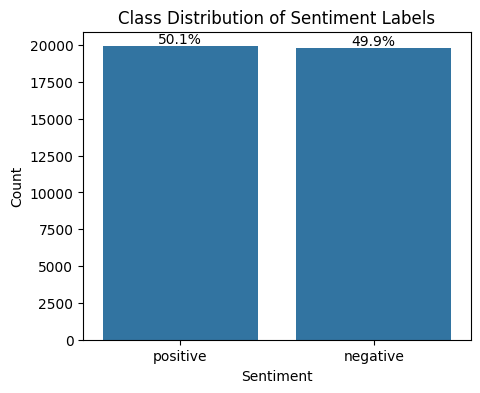

In [ ]:
# Plotting the sentiment distribution
plt.figure(figsize = (5, 4))
ax = sns.countplot(x = 'sentiment', data = df_train, order = df_train['sentiment'].value_counts().index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center', va = 'bottom')
plt.show()

The dataset shows a balanced distribution between positive and negative sentiments.

In [ ]:
# Text Length Analysis
df_train['text_length'] = df_train['review'].apply(len)

print("Sentiment distribution:")
print(df_train['sentiment'].value_counts())

print("\nText length statistics:")
print(df_train['text_length'].describe())

Sentiment distribution:
sentiment
positive    19923
negative    19805
Name: count, dtype: int64

Text length statistics:
count    39728.000000
mean      1311.359469
std        988.798970
min         41.000000
25%        699.000000
50%        971.500000
75%       1596.000000
max      13704.000000
Name: text_length, dtype: float64


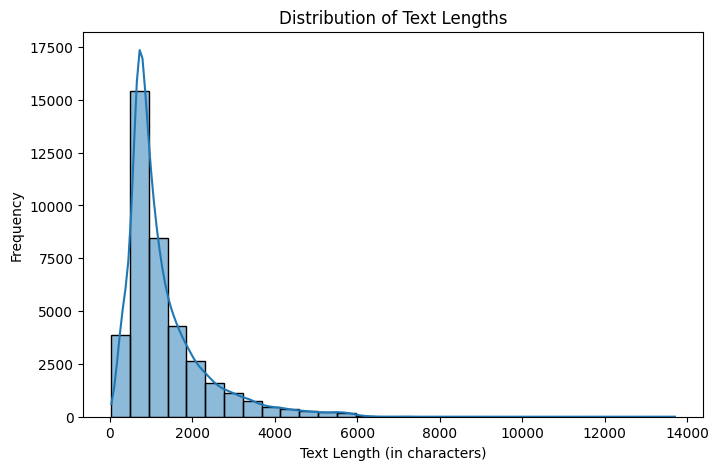

In [ ]:
# Plotting text length distribution
plt.figure(figsize = (8, 5))
sns.histplot(df_train['text_length'], bins = 30, kde = True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

Most texts fall within the range of 700 to 1500 characters, with the average length being 1311 characters.

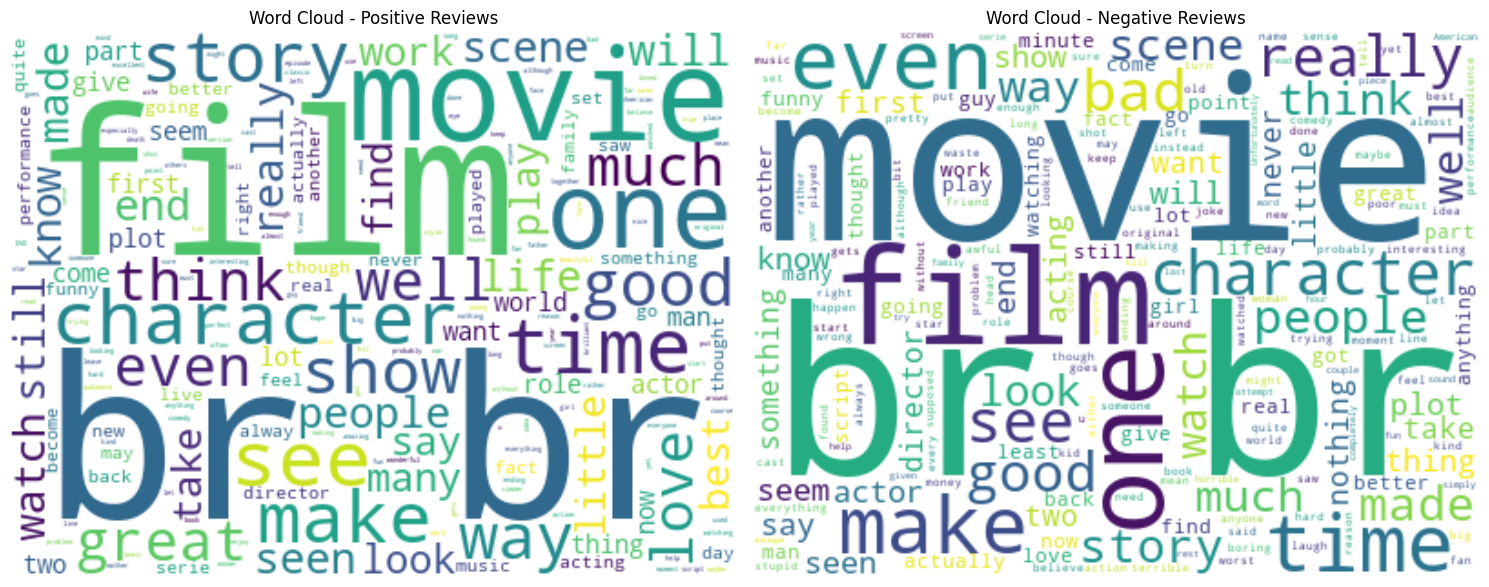

In [ ]:
# Word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
positive_reviews = df_train[df_train['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
negative_reviews = df_test[df_test['sentiment'] == 'negative']['review']
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()


**Summary of Key Insights:**

1. Sentiment Class Distribution:
    - Nearly equal distribution, indicating a balanced dataset for sentiment analysis.
2. Text Length Distribution:
    - The average length of texts is about 1311 characters.
    - Right-skewed distribution with most reviews between 699 and 1,596 characters.
    - Majority of reviews are concise, with fewer lengthy reviews.

In [ ]:
df_train.drop('text_length', axis = 1, inplace = True)

# Data Processing

This section focuses on preparing the text data for machine learning by applying various preprocessing techniques. We'll compare different text normalization methods (stemming vs lemmatization). We'll apply our preprocessing functions to the entire training dataset, creating two versions of the data: one with stemming and one with lemmatization. This allows us to compare the impact of different text normalization approaches on the final model performance and choose the most effective preprocessing strategy for our sentiment analysis task.

In [ ]:
df_train

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive
39996,"The first (and only) time I saw ""Shades"" was d...",negative
39997,This was such a waste of time. Danger: If you ...,negative
39998,this is by far the most pathetic movie Indian ...,negative


## Compare stemming vs lemmatization

Stemming is a simple and practical approach that involves cutting off the ends of words with the intention of obtaining the correct root form.
Lemmatization aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as 'lemma'. 

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Compare stemming vs lemmatization
print("Comparison of Stemming vs Lemmatization:")

# Test preprocessing on sample text
sample_text = df_train['review'].iloc[0]
print(f"\nOriginal text: {sample_text[:200]}...")

# Step by step preprocessing
cleaned_text = clean_text(sample_text)
print(f"\nCleaned text: {cleaned_text[:200]}...")

tokens = tokenize_text(cleaned_text)
print(f"\nTokenized (first 20): {tokens[:20]}")

tokens_no_stop = remove_stopwords(tokens)
print(f"\nWithout stopwords (first 20): {tokens_no_stop[:20]}")

stemmed_tokens = stem_tokens(tokens_no_stop)
print(f"\nStemmed (first 20): {stemmed_tokens[:20]}")

lemmatized_tokens = lemmatize_tokens(tokens_no_stop)
print(f"\nLemmatized (first 20): {lemmatized_tokens[:20]}")


Comparison of Stemming vs Lemmatization:

Original text: I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch o...

Cleaned text: i caught this little gem totally by accident back in  or  i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi shor...

Tokenized (first 20): ['i', 'caught', 'this', 'little', 'gem', 'totally', 'by', 'accident', 'back', 'in', 'or', 'i', 'was', 'at', 'a', 'revival', 'theatre', 'to', 'see', 'two']

Without stopwords (first 20): ['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'scifi', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch']

Stemmed (first 20): ['caught', 'littl', 'gem', 'total', 'accid', 'back', 'reviv', 'theatr', 'see', 'two', 'old', 'silli',

**Key Observations**
1. **STEMMING EFFECTS:**
    - 'little' → 'littl' (over-stemmed, creates non-word)
    - 'totally' → 'total' (correctly removes suffix)
    - 'accident' → 'accid' (over-stemmed, loses meaning)
    - 'silly' → 'silli' (incorrect stem)
    - 'movies' → 'movi' (over-stemmed)
    - 'warning' → 'warn' (correctly removes suffix)

2. **LEMMATIZATION EFFECTS:**
    - 'little' → 'little' (preserved, correct word)
    - 'totally' → 'totally' (preserved, adverb form)
    - 'accident' → 'accident' (preserved, correct word)
    - 'silly' → 'silly' (preserved, correct word)
    - 'movies' → 'movie' (correctly singularized)
    - 'warning' → 'warning' (preserved, correct word)

- **Stemming:** Faster processing, smaller vocabulary, but creates non-words
- **Lemmatization:** Preserves word meaning, maintains readability
- Stemmed tokens contain artificial roots like 'littl', 'accid', 'silli'
- Lemmatized tokens maintain real dictionary words

## Basic processing

In [ ]:
# Create copies for different preprocessing approaches
train_stemmed    = df_train.copy()
train_lemmatized = df_train.copy()

train_stemmed['processed_review']    = [preprocess_text(text, use_stemming = True, use_lemmatization = False) for text in train_stemmed['review']]
train_lemmatized['processed_review'] = [preprocess_text(text, use_stemming = False, use_lemmatization = True) for text in train_lemmatized['review']]

In [ ]:
# Compare processing results
print("\nComparison of preprocessing approaches:")
sample_idx = 11
print(f"Original: {df_train['review'].iloc[sample_idx][:500]}...")
print(f"Stemmed: {train_stemmed['processed_review'].iloc[sample_idx][:500]}...")
print(f"Lemmatized: {train_lemmatized['processed_review'].iloc[sample_idx][:500]}...")


Comparison of preprocessing approaches:
Original: Because 'cruel' would be the only word in existence to describe the intentions of these film makers. Where do you even begin? In a spout of b*tchiness, I'm going to start with the awful acting of nearly everybody in this movie. Scratch that. Nearly does not belong in that sentence. I can't think of even one character who was portrayed well. Although, in all fairness, it would be nearly impossible to portray these zero dimensional characters in a successful way. Still, the girl who played Katheri...
Stemmed: cruel would word exist describ intent film maker even begin spout btchiness im go start aw act near everybodi movi scratch near belong sentenc cant think even one charact portray well although fair would near imposs portray zero dimension charact success way still girl play katherin whose name purpos dont includ im pretend doesnt exist remain one worst actor ive ever seen eclips guy play sebastian stori god aw attempt mirror brillia

In [ ]:
display(train_stemmed.head(5), train_lemmatized.head(5))

,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught littl gem total accid back reviv theatr...
1,I can't believe that I let myself into this mo...,negative,cant believ let movi accomplish favor friend a...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerv peopl remak use term lo...
3,If there's one thing I've learnt from watching...,negative,there one thing ive learnt watch georg romero ...
4,"I remember when this was in theaters, reviews ...",negative,rememb theater review said horribl well didnt ...


,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,cant believe let movie accomplish favor friend...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerve people remake use term...
3,If there's one thing I've learnt from watching...,negative,there one thing ive learnt watching george rom...
4,"I remember when this was in theaters, reviews ...",negative,remember theater review said horrible well did...


- Lemmatized version maintains clearer semantic meaning, it remains more human-readable
- Stemmed text is harder to interpret due to truncated words
- Stemming reduces vocabulary more aggressively
- Lemmatization provides balanced vocabulary reduction
- Both remove stopwords and normalize case effectively

## Vectorization

This section converts our preprocessed text data into numerical representations that machine learning models can process. We'll explore two fundamental vectorization techniques: Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF), applying both to our stemmed and lemmatized datasets to determine the optimal combination for sentiment analysis.

In [ ]:
# Prepare data for vectorization
X_text_stemmed    = train_stemmed['processed_review']
X_text_lemmatized = train_lemmatized['processed_review']
y = df_train['sentiment']

# Encode labels
encoder   = LabelEncoder()
y_test = encoder.fit_transform(y)

# Split data for evaluation
X_train_stem, X_val_stem, y_train, y_val = train_test_split(X_text_stemmed, y_test, test_size = 0.2, random_state = 42, stratify = y_test)
X_train_lem, X_val_lem, _, _ = train_test_split(X_text_lemmatized, y_test, test_size = 0.2, random_state = 42, stratify = y_test)

### Bag of Words (BoW) vs Term Frequency-Inverse Document Frequency (TF-IDF)

The **Bag of Words** model represents text by converting it into a collection of words and their frequencies, completely disregarding grammar, word order, and context. Each document becomes a vector where each dimension corresponds to a unique word in the vocabulary, and the value represents how many times that word appears in the document. This approach treats text as an unordered collection of words, hence the term "bag" of words. While simple and computationally efficient, BoW captures the presence and frequency of important terms but loses sequential information and context that might be crucial for understanding sentiment nuances.

**TF-IDF** builds upon the BoW concept but addresses one of its major limitations by considering not just how frequently a word appears in a document, but also how rare or common that word is across the entire corpus. The Term Frequency component measures how often a word appears in a specific document, while the Inverse Document Frequency component reduces the weight of words that appear frequently across many documents. This approach helps identify words that are particularly characteristic of individual documents rather than common across the entire dataset. For sentiment analysis, TF-IDF can be particularly valuable because it emphasizes distinctive words that might be strong sentiment indicators while downweighting common words that appear in both positive and negative reviews.

In [ ]:
count_vectorizer_stem = CountVectorizer(max_features = 5000)
count_vectorizer_lem  = CountVectorizer(max_features = 5000)

# Stemmed + Count
X_train_count_stem = count_vectorizer_stem.fit_transform(X_train_stem)
X_val_count_stem   = count_vectorizer_stem.transform(X_val_stem)

# Lemmatized + Count
X_train_count_lem = count_vectorizer_lem.fit_transform(X_train_lem)
X_val_count_lem   = count_vectorizer_lem.transform(X_val_lem)

In [ ]:
print(f"Count (Stemmed) - Training shape: {X_train_count_stem.shape}")
print(f"Count (Stemmed) - Validation shape: {X_val_count_stem.shape}")
print(f"Count (Lemmatized) - Training shape: {X_train_count_lem.shape}")
print(f"Count (Lemmatized) - Validation shape: {X_val_count_lem.shape}")

Count (Stemmed) - Training shape: (31782, 5000)
Count (Stemmed) - Validation shape: (7946, 5000)
Count (Lemmatized) - Training shape: (31782, 5000)
Count (Lemmatized) - Validation shape: (7946, 5000)


In [ ]:
tfidf_vectorizer_stem = TfidfVectorizer(max_features = 5000)
tfidf_vectorizer_lem  = TfidfVectorizer(max_features = 5000)

# Stemmed + TF-IDF
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train_stem)
X_val_tfidf_stem   = tfidf_vectorizer_stem.transform(X_val_stem)

# Lemmatized + TF-IDF
X_train_tfidf_lem = tfidf_vectorizer_lem.fit_transform(X_train_lem)
X_val_tfidf_lem   = tfidf_vectorizer_lem.transform(X_val_lem)

In [ ]:
print(f"TF-IDF (Stemmed) - Training shape: {X_train_tfidf_stem.shape}")
print(f"TF-IDF (Stemmed) - Validation shape: {X_val_tfidf_stem.shape}")
print(f"TF-IDF (Lemmatized) - Training shape: {X_train_tfidf_lem.shape}")
print(f"TF-IDF (Lemmatized) - Validation shape: {X_val_tfidf_lem.shape}")

TF-IDF (Stemmed) - Training shape: (31782, 5000)
TF-IDF (Stemmed) - Validation shape: (7946, 5000)
TF-IDF (Lemmatized) - Training shape: (31782, 5000)
TF-IDF (Lemmatized) - Validation shape: (7946, 5000)


# Models training

This section implements and evaluates multiple machine learning models across different text preprocessing and vectorization combinations. We'll systematically compare model performance to identify the optimal approach for sentiment classification, followed by hyperparameter tuning to maximize the performance of our best models.

In [ ]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1000),
    'Random Forest': RandomForestClassifier(random_state = 42, n_estimators = 100),
    'Naive Bayes': MultinomialNB()
}

# Data combinations to compare
data_combinations = {
    'Stemmed + Count': (X_train_count_stem, X_val_count_stem),
    'Lemmatized + Count': (X_train_count_lem, X_val_count_lem),
    'Stemmed + TF-IDF': (X_train_tfidf_stem, X_val_tfidf_stem),
    'Lemmatized + TF-IDF': (X_train_tfidf_lem, X_val_tfidf_lem)
}

results = {}


==================== Stemmed + Count ====================

Training Logistic Regression...


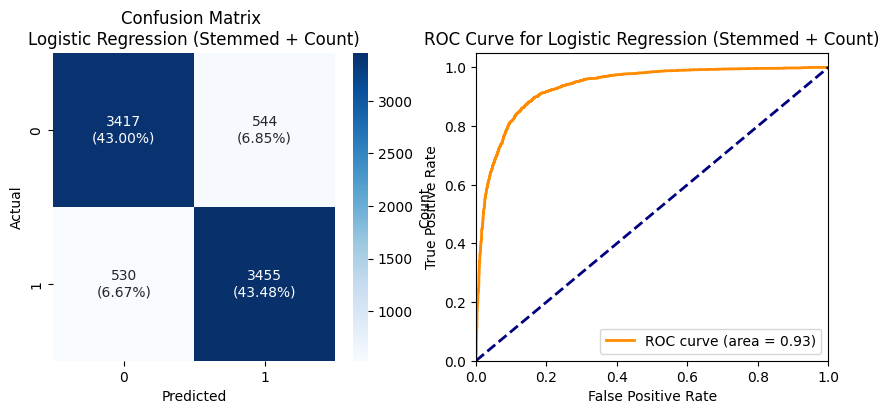


Logistic Regression (Stemmed + Count) Results:
Accuracy:  0.8648
Precision: 0.8640
Recall:    0.8670
F1-Score:  0.8655
ROC-AUC:   0.9348

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      3961
           1       0.86      0.87      0.87      3985

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.86      7946
weighted avg       0.86      0.86      0.86      7946


Training Random Forest...


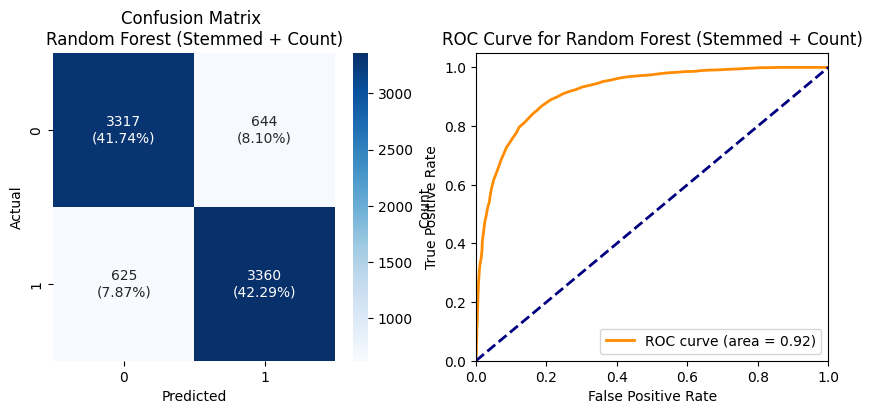


Random Forest (Stemmed + Count) Results:
Accuracy:  0.8403
Precision: 0.8392
Recall:    0.8432
F1-Score:  0.8412
ROC-AUC:   0.9175

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


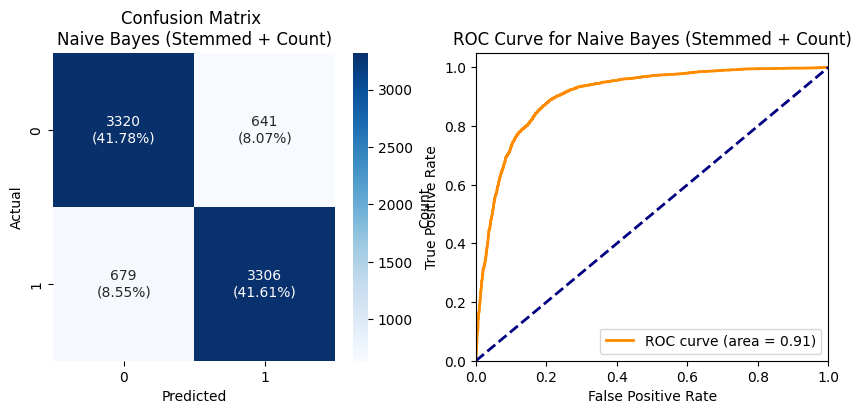


Naive Bayes (Stemmed + Count) Results:
Accuracy:  0.8339
Precision: 0.8376
Recall:    0.8296
F1-Score:  0.8336
ROC-AUC:   0.9067

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      3961
           1       0.84      0.83      0.83      3985

    accuracy                           0.83      7946
   macro avg       0.83      0.83      0.83      7946
weighted avg       0.83      0.83      0.83      7946


==================== Lemmatized + Count ====================

Training Logistic Regression...


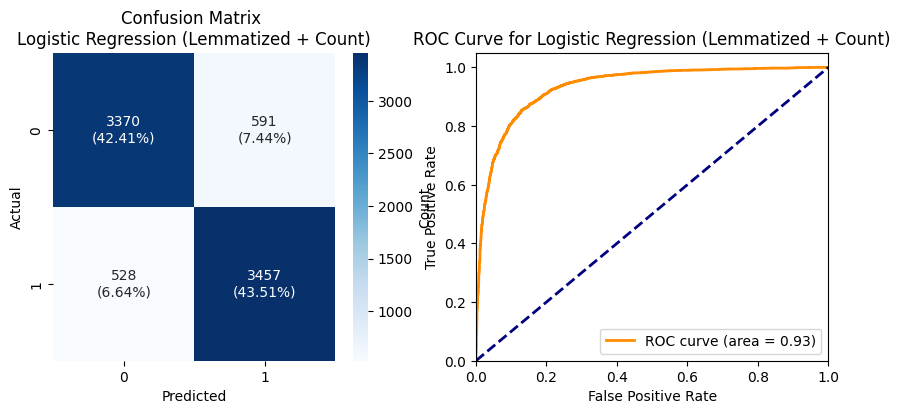


Logistic Regression (Lemmatized + Count) Results:
Accuracy:  0.8592
Precision: 0.8540
Recall:    0.8675
F1-Score:  0.8607
ROC-AUC:   0.9342

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      3961
           1       0.85      0.87      0.86      3985

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.86      7946
weighted avg       0.86      0.86      0.86      7946


Training Random Forest...


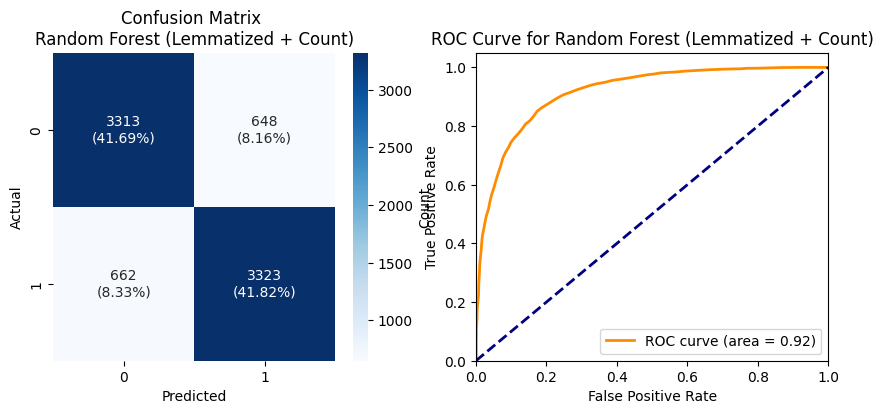


Random Forest (Lemmatized + Count) Results:
Accuracy:  0.8351
Precision: 0.8368
Recall:    0.8339
F1-Score:  0.8353
ROC-AUC:   0.9151

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      3961
           1       0.84      0.83      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


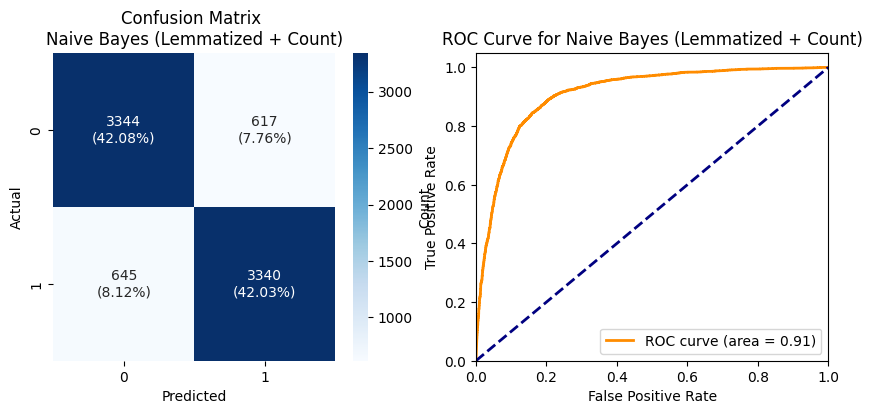


Naive Bayes (Lemmatized + Count) Results:
Accuracy:  0.8412
Precision: 0.8441
Recall:    0.8381
F1-Score:  0.8411
ROC-AUC:   0.9099

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


==================== Stemmed + TF-IDF ====================

Training Logistic Regression...


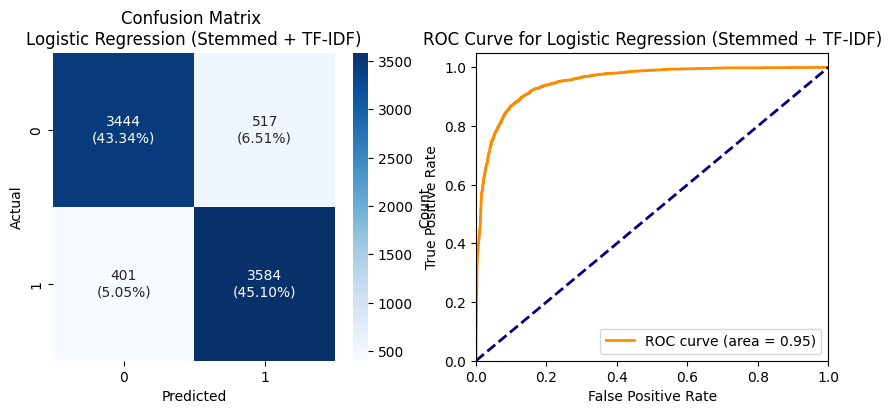


Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8845
Precision: 0.8739
Recall:    0.8994
F1-Score:  0.8865
ROC-AUC:   0.9517

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


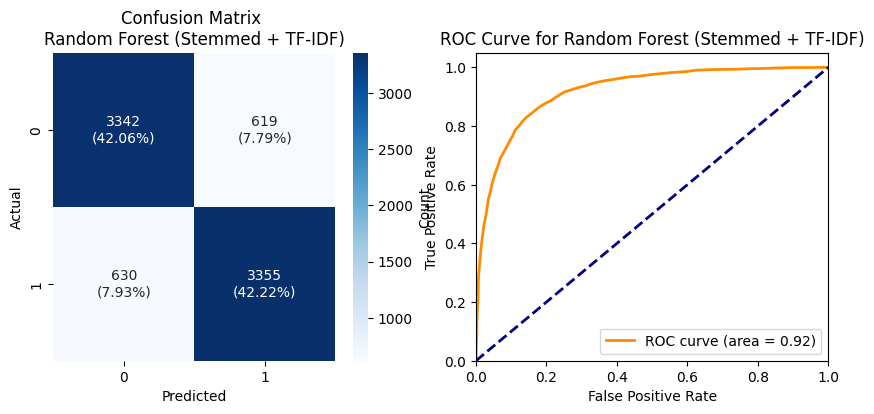


Random Forest (Stemmed + TF-IDF) Results:
Accuracy:  0.8428
Precision: 0.8442
Recall:    0.8419
F1-Score:  0.8431
ROC-AUC:   0.9195

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


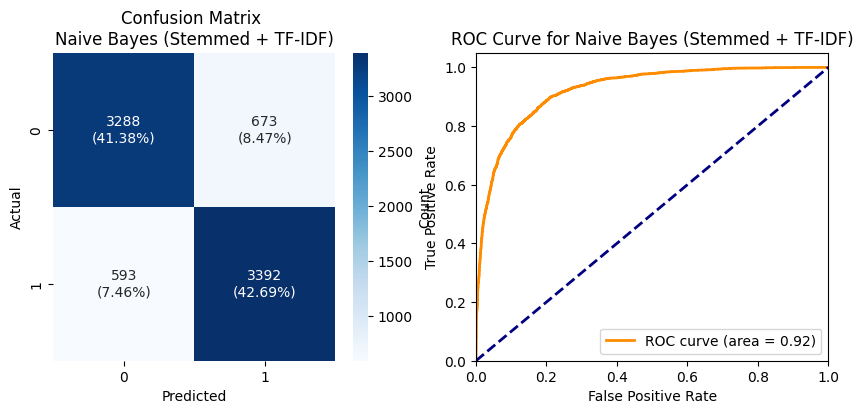


Naive Bayes (Stemmed + TF-IDF) Results:
Accuracy:  0.8407
Precision: 0.8344
Recall:    0.8512
F1-Score:  0.8427
ROC-AUC:   0.9229

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3961
           1       0.83      0.85      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


==================== Lemmatized + TF-IDF ====================

Training Logistic Regression...


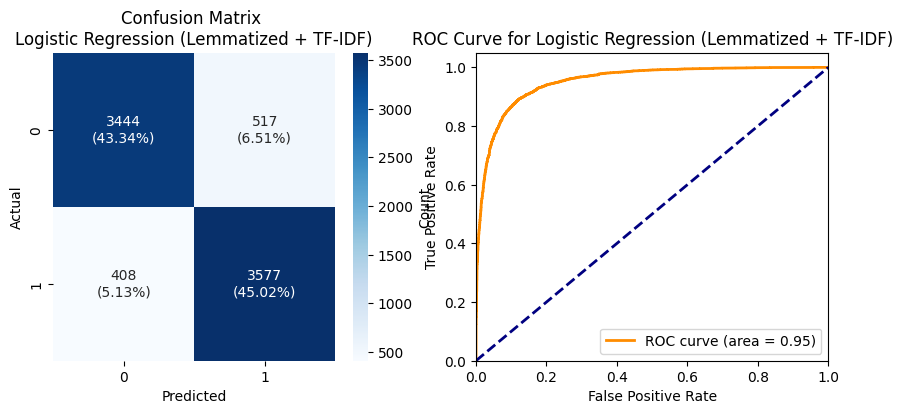


Logistic Regression (Lemmatized + TF-IDF) Results:
Accuracy:  0.8836
Precision: 0.8737
Recall:    0.8976
F1-Score:  0.8855
ROC-AUC:   0.9518

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


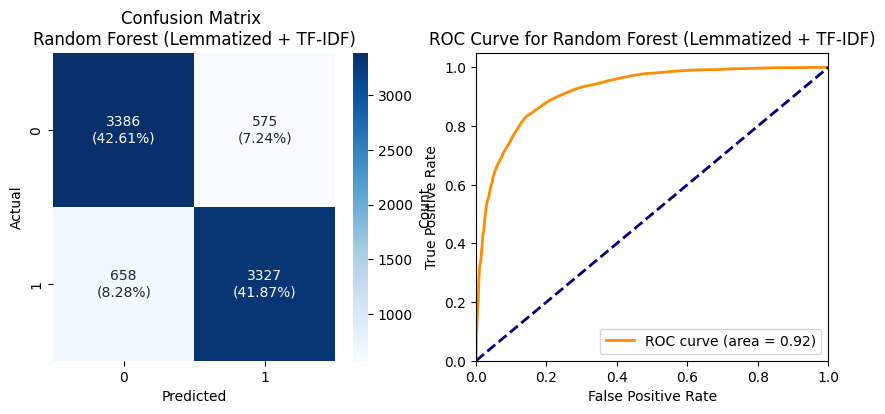


Random Forest (Lemmatized + TF-IDF) Results:
Accuracy:  0.8448
Precision: 0.8526
Recall:    0.8349
F1-Score:  0.8437
ROC-AUC:   0.9199

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      3961
           1       0.85      0.83      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


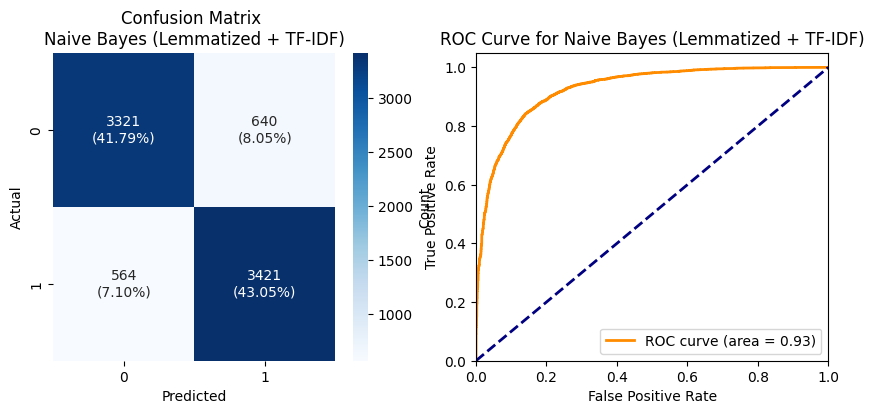


Naive Bayes (Lemmatized + TF-IDF) Results:
Accuracy:  0.8485
Precision: 0.8424
Recall:    0.8585
F1-Score:  0.8504
ROC-AUC:   0.9260

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3961
           1       0.84      0.86      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946



In [ ]:
# Test each model with each data configuration
for config_name, (X_train_data, X_val_data) in data_combinations.items():
    print(f"\n{'='*20} {config_name} {'='*20}")
    
    config_results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Train model
        model.fit(X_train_data, y_train)
        
        # Evaluate model
        metrics = evaluate_cls_model(model, X_val_data, y_val, f"{model_name} ({config_name})", return_metrics = True)
        
        config_results[model_name] = metrics
    
    results[config_name] = config_results

In [ ]:
comparison_data = []
for config in results:
    for model in results[config]:
        metrics = results[config][model]
        comparison_data.append({
            'Configuration': config,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(3)
comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
comparison_df


Complete Results Summary:


,Configuration,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
9,Lemmatized + TF-IDF,Logistic Regression,0.884,0.874,0.898,0.886,0.952
6,Stemmed + TF-IDF,Logistic Regression,0.884,0.874,0.899,0.886,0.952
0,Stemmed + Count,Logistic Regression,0.865,0.864,0.867,0.865,0.935
3,Lemmatized + Count,Logistic Regression,0.859,0.854,0.868,0.861,0.934
11,Lemmatized + TF-IDF,Naive Bayes,0.848,0.842,0.858,0.850,0.926
10,Lemmatized + TF-IDF,Random Forest,0.845,0.853,0.835,0.844,0.920
7,Stemmed + TF-IDF,Random Forest,0.843,0.844,0.842,0.843,0.919
8,Stemmed + TF-IDF,Naive Bayes,0.841,0.834,0.851,0.843,0.923
5,Lemmatized + Count,Naive Bayes,0.841,0.844,0.838,0.841,0.910
1,Stemmed + Count,Random Forest,0.840,0.839,0.843,0.841,0.917


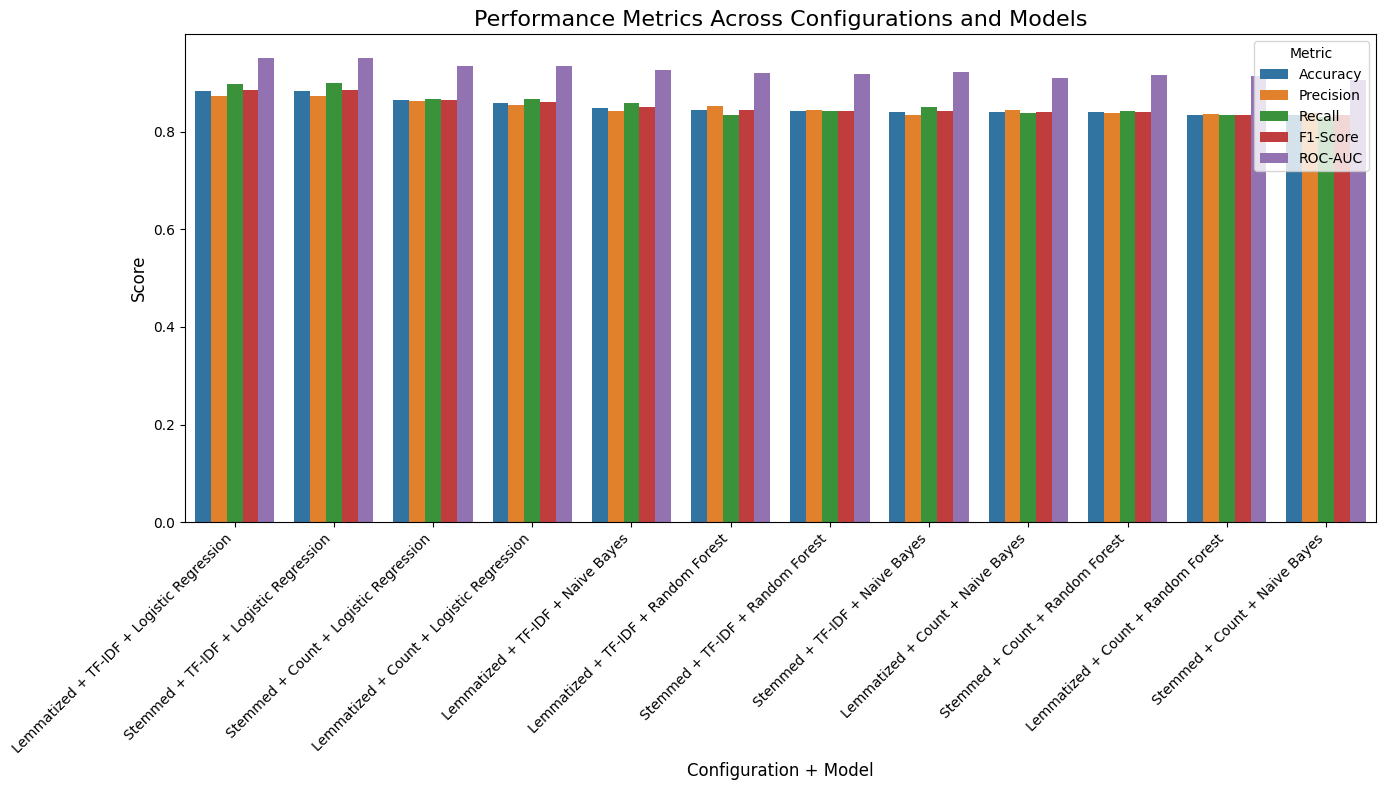

In [ ]:
df_plot = comparison_df.copy()
df_plot['Config_Model'] = df_plot['Configuration'] + ' + ' + df_plot['Model']
df_melted = pd.melt(df_plot, 
                    id_vars = ['Config_Model'], 
                    value_vars = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                    var_name = 'Metric', 
                    value_name = 'Score')

plt.figure(figsize = (14, 8))
bar_plot = sns.barplot(x = 'Config_Model', y = 'Score', hue = 'Metric', data = df_melted)
plt.title('Performance Metrics Across Configurations and Models', fontsize = 16)
plt.xlabel('Configuration + Model', fontsize = 12)
plt.ylabel('Score', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.legend(title = 'Metric', loc = 'upper right')
plt.tight_layout()

**STEMMED + COUNT**
- **Logistic Regression:** Achieves the highest accuracy, with balanced precision (0.8640) and recall (0.8670), an F1-score of 0.8655, and a strong ROC-AUC of 0.9348. This suggests robust performance across both classes.
- **Random Forest:** Slightly lower accuracy, with consistent precision (0.8392) and recall (0.8432), F1-score of 0.8412, and ROC-AUC of 0.9175, indicating good but less optimal performance compared to Logistic Regression.
- **Naive Bayes:** Lowest accuracy (0.8339) among the three, with precision (0.8376) slightly exceeding recall (0.8296), F1-score of 0.8336, and ROC-AUC of 0.9067, showing moderate performance.

**LEMMATIZED + COUNT**
- **Logistic Regression:** Slightly lower accuracy than its stemmed counterpart, with precision (0.8540) and recall (0.8675) yielding an F1-score of 0.8607 and ROC-AUC of 0.9342. Performance remains strong but marginally less effective.
- **Random Forest:** Accuracy, precision (0.8368), and recall (0.8339) are closely aligned, with an F1-score of 0.8353 and ROC-AUC of 0.9151, showing stable but slightly weaker results.
- **Naive Bayes:** Improves over stemmed version with accuracy, precision (0.8441), and recall (0.8381), F1-score of 0.8411, and ROC-AUC of 0.9099, indicating lemmatization benefits this model.

**STEMMED + TF-IDF**
- **Logistic Regression:** Outperforms all configurations with accuracy, precision (0.8739), and recall (0.8994), F1-score of 0.8865, and the highest ROC-AUC (0.9517), highlighting TF-IDF's effectiveness with Logistic Regression.
- **Random Forest:** Accuracy, precision (0.8442), and recall (0.8419) are balanced, with an F1-score of 0.8431 and ROC-AUC of 0.9195, showing a modest improvement over Count-based features.
- **Naive Bayes:** Accuracy, with precision (0.8344) and recall (0.8512), F1-score of 0.8427, and ROC-AUC of 0.9229, indicating a slight edge over Count-based results.

**LEMMATIZED + TF-IDF**
- **Logistic Regression:** Nearly matches stemmed TF-IDF with accuracy, precision (0.8737), and recall (0.8976), F1-score of 0.8855, and ROC-AUC of 0.9518, confirming TF-IDF and Logistic Regression as a top combination.
- **Random Forest:** Accuracy, with precision (0.8526) and recall (0.8349), F1-score of 0.8437, and ROC-AUC of 0.9199, showing a slight improvement over other Random Forest models.
- **Naive Bayes:** Best Naive Bayes performance with  precision (0.8424), and recall (0.8585), F1-score of 0.8504, and ROC-AUC of 0.9260, benefiting from TF-IDF.

------------------------------------------------------------------------------------------------------------------------------------------------
Based on the performance results, here are the recommended combinations for each of the three models to tune parameters, selected for their strong baseline performance and potential for improvement:
- Logistic Regression: Stemmed + TF-IDF
- Random Forest: Stemmed + TF-IDF
- Naive Bayes: Lemmatized + TF-IDF

## Hyperparameters tuning

In [ ]:
# Hyperparameter grids
param_grids = {
    'Logistic Regression': [
        {'solver': ['liblinear'], 'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
        {'solver': ['lbfgs'], 'C': [0.1, 1, 10, 100], 'penalty': ['l2']}
    ],
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
}

best_models_combs = {
    'Logistic Regression' : 'Stemmed + TF-IDF',
    'Random Forest'       : 'Lemmatized + TF-IDF',
    'Naive Bayes'         : 'Stemmed + TF-IDF'
}

In [ ]:
# Perform hyperparameter tuning
tuned_models = {}

for model_name, config in best_models_combs.items():
    print(f"\nTuning {model_name}...")

    X_train, X_val = data_combinations[config]

    # Initialize model
    if model_name == 'Logistic Regression':
        model = LogisticRegression(random_state = 42)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state = 42)
    elif model_name == 'Naive Bayes':
        model = MultinomialNB()

    random_search = RandomizedSearchCV(model, param_grids[model_name], scoring = 'f1', cv = 5, verbose = 0, n_jobs = -1)

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    
    tuned_models[model_name] = {
        'model': random_search.best_estimator_,
        'params': random_search.best_params_,
        'cv_score': random_search.best_score_
    }


Tuning Logistic Regression...
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best CV score: 0.8823

Tuning Random Forest...
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.8464

Tuning Naive Bayes...


c:\projects\traffic-code-exam-queue-checker-master\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 2.0}
Best CV score: 0.8470


In [ ]:
tuned_models

{'Logistic Regression': {'model': LogisticRegression(C=1, random_state=42, solver='liblinear'),
  'params': {'solver': 'liblinear', 'penalty': 'l2', 'C': 1},
  'cv_score': np.float64(0.8823455158526275)},
 'Random Forest': {'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42),
  'params': {'n_estimators': 200,
   'min_samples_split': 2,
   'min_samples_leaf': 2,
   'max_depth': None},
  'cv_score': np.float64(0.8463847989634476)},
 'Naive Bayes': {'model': MultinomialNB(alpha=2.0),
  'params': {'alpha': 2.0},
  'cv_score': np.float64(0.8470295020466923)}}


==================== Evaluating tuned Logistic Regression ====================


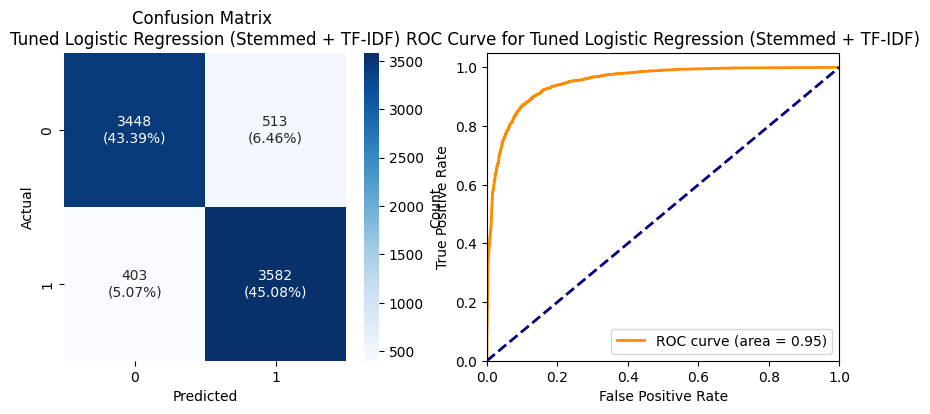


Tuned Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8847
Precision: 0.8747
Recall:    0.8989
F1-Score:  0.8866
ROC-AUC:   0.9517

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.89      0.88      0.88      7946
weighted avg       0.89      0.88      0.88      7946


==================== Evaluating tuned Random Forest ====================


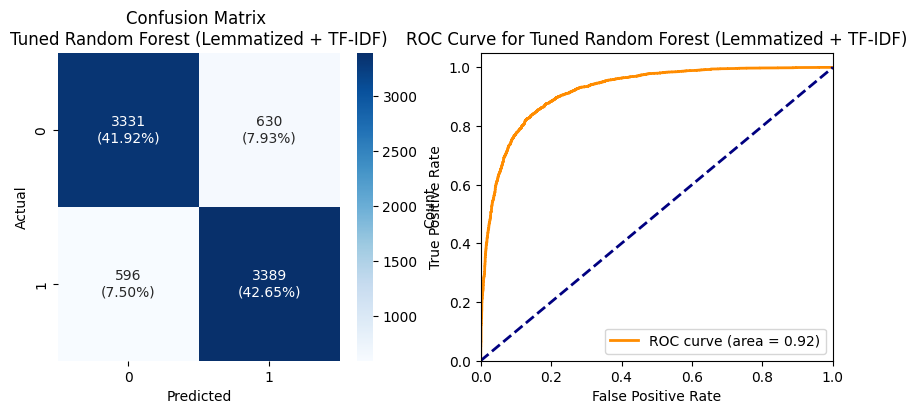


Tuned Random Forest (Lemmatized + TF-IDF) Results:
Accuracy:  0.8457
Precision: 0.8432
Recall:    0.8504
F1-Score:  0.8468
ROC-AUC:   0.9221

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      3961
           1       0.84      0.85      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


==================== Evaluating tuned Naive Bayes ====================


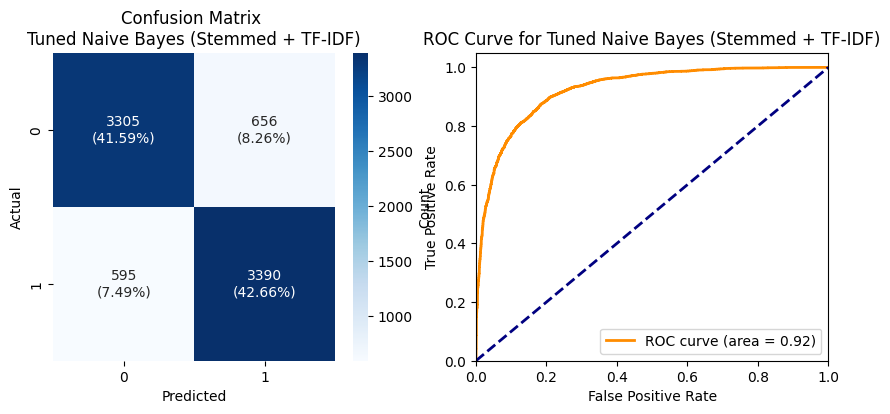


Tuned Naive Bayes (Stemmed + TF-IDF) Results:
Accuracy:  0.8426
Precision: 0.8379
Recall:    0.8507
F1-Score:  0.8442
ROC-AUC:   0.9237

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3961
           1       0.84      0.85      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946



In [ ]:
config_results = {}

for model_name, model_info in tuned_models.items():
    print(f"\n{'='*20} Evaluating tuned {model_name} {'='*20}")
    
    # Get data configuration
    config = best_models_combs[model_name]
    X_train, X_val = data_combinations[config]
    
    # Evaluate model
    metrics = evaluate_cls_model(model_info['model'], X_val, y_val, f"Tuned {model_name} ({config})", return_metrics = True)
        
    config_results[model_name] = metrics

In [ ]:
# Initialize comparison data
comparison_data = []
for model_name in config_results:
    metrics = config_results[model_name]
    comparison_data.append({
        'Model': model_name,
        'Configuration': best_models_combs[model_name],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
    })

# Create and sort DataFrame
tuned_comparison_df = pd.DataFrame(comparison_data)
tuned_comparison_df = tuned_comparison_df.round(3)
tuned_comparison_df = tuned_comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
tuned_comparison_df


Complete Results Summary:


,Model,Configuration,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,Stemmed + TF-IDF,0.885,0.875,0.899,0.887,0.952
1,Random Forest,Lemmatized + TF-IDF,0.846,0.843,0.850,0.847,0.922
2,Naive Bayes,Stemmed + TF-IDF,0.843,0.838,0.851,0.844,0.924


**TUNING RESULTS**

**Tuned Logistic Regression (Stemmed + TF-IDF):**
- Accuracy: 0.8847 (slight improvement from 0.8845)
- Precision: 0.8747, Recall: 0.8989, F1-Score: 0.8866
- ROC-AUC: 0.9517 (unchanged)
- Classification Report: Balanced performance with 0.90 precision and 0.87 recall for class 0, and 0.87 precision with 0.90 recall for class 1.
- Insight: Minimal improvement suggests the baseline was near-optimal, but tuning refined class balance.

**Tuned Random Forest (Stemmed + TF-IDF):**
- Accuracy: 0.8457 (improvement from 0.8448)
- Precision: 0.8432, Recall: 0.8504, F1-Score: 0.8468
- ROC-AUC: 0.9221 (improvement from 0.9199)
- Classification Report: Consistent precision (0.85) and recall (0.84-0.85) across classes.
- Insight: Tuning enhanced overall performance, particularly in ROC-AUC, indicating better discrimination.

**Tuned Naive Bayes (Stemmed + TF-IDF):**
- Accuracy: 0.8426 (improvement from 0.8407 with Lemmatized + TF-IDF)
- Precision: 0.8379, Recall: 0.8507, F1-Score: 0.8442
- ROC-AUC: 0.9237 (improvement from 0.9260 with Lemmatized)
- Classification Report: Balanced precision (0.85) and recall (0.83-0.85) across classes.
- Insight: Switching to Stemmed + TF-IDF and tuning alpha improved accuracy and F1-score, though ROC-AUC slightly declined.

------------------------------------------------------------------------------------------------------------------------------------------------
**Best Model:** Tuned Logistic Regression (Stemmed + TF-IDF) remains the top performer with an accuracy of 0.8847 and F1-score of 0.8866, closely matching its untuned version but with refined class predictions.

All models saw slight gains post-tuning, with Logistic Regression showing the least relative improvement (due to its already high baseline), while Random Forest and Naive Bayes benefited more noticeably.

Logistic Regression continues to excel, likely due to its linear nature aligning well with TF-IDF features. Random Forest benefits from increased trees, and Naive Bayes improves with adjusted smoothing.

In [ ]:
import joblib

# Retrieve the tuned Logistic Regression model (Stemmed + TF-IDF)
lr_model = tuned_models['Logistic Regression']['model']

# Save the model to the specified path
joblib.dump(lr_model, '../models/lr_stemmed_tfidf.pkl')

['../models/lr_stemmed_tfidf.pkl']

# Bert

This section implements a sentiment classification model using DistilBERT, a lightweight and efficient version of BERT that maintains competitive performance while being significantly faster and requiring less computational resources.

In [ ]:
SEED = 42
def set_seed(seed = SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Initialize random seeds for consistent results across runs
set_seed()

# Detect and set the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Prepare data
label_enc = LabelEncoder()
df_train["label"] = label_enc.fit_transform(df_train["sentiment"])

train_df, val_df = train_test_split(df_train[["review","label"]], test_size = 0.2, stratify = df_train["label"], random_state = SEED)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

# Tokenizer & token-level dataset
MODEL_NAME = "distilbert-base-uncased"       
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME) # Load the tokenizer associated with the model

def tokenize_function(example, max_len = 128):
    """Tokenize text data for BERT input format."""
    return tokenizer(
        example["review"],
        padding = "max_length",
        truncation = True,
        max_length = max_len,
    )

# Apply tokenization to all examples in the datasets
train_ds = train_ds.map(tokenize_function, batched = True, remove_columns = ["review"])
val_ds   = val_ds.map(tokenize_function, batched = True, remove_columns = ["review"])

# Set dataset format to PyTorch tensors for model compatibility
train_ds.set_format(type = "torch", columns = ["input_ids", "attention_mask", "label"])
val_ds.set_format(type = "torch",   columns = ["input_ids", "attention_mask", "label"])

# Model
num_labels = len(label_enc.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels = num_labels
).to(device)

# Metrics
accuracy = load_metric("accuracy")
f1       = load_metric("f1")

# Load evaluation metrics from Hugging Face datasets library
def compute_metrics(eval_pred):
    """Compute evaluation metrics during training and validation."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = 1)
    return {
        "accuracy": accuracy.compute(predictions = preds, references = labels)["accuracy"],
        "f1":       f1.compute(predictions = preds, references = labels, average = "weighted")["f1"],
    }

# Configure training parameters
training_args = TrainingArguments(
    output_dir          = "./sentiment_distilbert",
    eval_strategy       = "epoch", 
    save_strategy       = "epoch",
    save_total_limit    = 2,
    load_best_model_at_end = True,
    metric_for_best_model  = "f1",
    greater_is_better      = True,
    num_train_epochs    = 6,
    per_device_train_batch_size  = 16,
    per_device_eval_batch_size   = 16,
    learning_rate       = 2e-5,
    weight_decay        = 0.01,
    fp16                = torch.cuda.is_available(),
    logging_dir         = "./logs",
    logging_steps       = 50,
    report_to           = "none",
    seed                = SEED,
)

# Initialize the Trainer with all components
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience = 2)]
)

# Train
trainer.train()

# Evaluate & save
metrics = trainer.evaluate()
print("Validation metrics:", metrics)

# Save the best model and tokenizer
trainer.save_model("./bert")  
tokenizer.save_pretrained("./bert")

Using cuda


Map: 100%|██████████| 8000/8000 [00:01<00:00, 6194.10 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vladp\AppData\Local\Temp\ipykernel_38452\4008979465.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.363000,0.285945,0.876750,0.876746
2,0.197100,0.347882,0.881625,0.881625
3,0.171900,0.436362,0.876500,0.876439
4,0.121400,0.569779,0.880125,0.880065


Validation metrics: {'eval_loss': 0.3478817045688629, 'eval_accuracy': 0.881625, 'eval_f1': 0.8816249981503906, 'eval_runtime': 9.8032, 'eval_samples_per_second': 816.057, 'eval_steps_per_second': 51.004, 'epoch': 4.0}


('./bert\\tokenizer_config.json',
 './bert\\special_tokens_map.json',
 './bert\\vocab.txt',
 './bert\\added_tokens.json',
 './bert\\tokenizer.json')

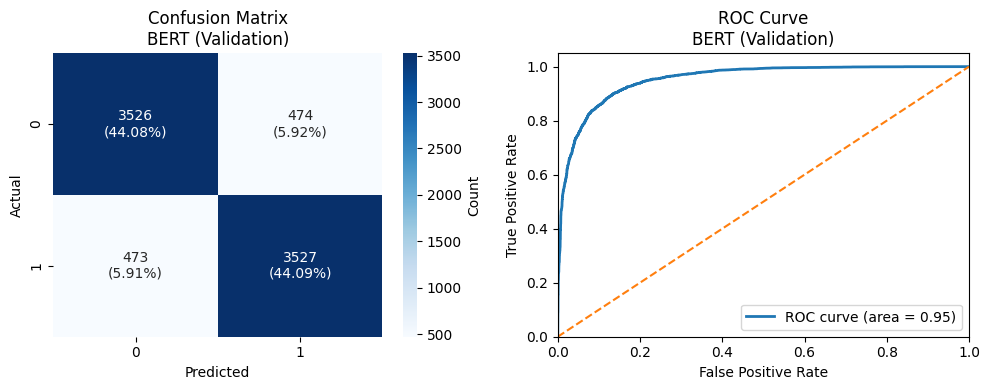


BERT (Validation) Results:
Accuracy:  0.8816
Precision: 0.8815
Recall:    0.8818
F1-Score:  0.8816
ROC-AUC:   0.9524

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.88      0.88      4000
    positive       0.88      0.88      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



In [ ]:
bert_metrics = evaluate_bert(trainer, val_ds, label_enc, name = "BERT (Validation)")

- DistilBERT achieves a strong balance across metrics, benefiting from its contextual understanding of text. The high ROC-AUC (0.9524) indicates excellent class separation, while the balanced precision and recall reflect the model's ability to handle the near-equal sentiment distribution.
- The validation loss increase after epoch 2 (0.285945 to 0.569779) and the drop in accuracy/F1 at epoch 3 suggest overfitting, mitigated by early stopping. The best model at epoch 2 aligns with the highest F1-score.
- DistilBERT outperforms the tuned Logistic Regression slightly in ROC-AUC but falls short in accuracy and F1-score. It surpasses Random Forest and Naive Bayes across all metrics.
- *Vs. Logistic Regression:* DistilBERT’s ROC-AUC edge and comparable accuracysuggest it captures nuanced patterns better, though it may underperform slightly due to early stopping or hyperparameter settings.
- *Vs. Random Forest/Naive Bayes:* Significant improvement over both, highlighting the advantage of transformer-based models over traditional ML approaches for text classification.

# Best models comparison on test set

Based on the performance metrics across all evaluated models, the two top-performing models to compare on the test set are:
1. Tuned Logistic Regression (Stemmed + TF-IDF):
    - This model achieved the highest accuracy and F1-score among the traditional machine learning approaches, with a strong ROC-AUC, making it a robust baseline for comparison.
2. BERT (DistilBERT - Validation):
    - This transformer-based model showed the highest ROC-AUC and competitive accuracy/F1-score, leveraging contextual understanding, which positions it as a top contender despite early stopping.

In [43]:
# Prepare test set for Logistic Regression testing
test_stemmed  = df_test.copy()
test_stemmed['processed_review'] = [preprocess_text(text, use_stemming = True, use_lemmatization = False) for text in test_stemmed['review']]
X_test_stem = test_stemmed['processed_review']

y = df_test['sentiment']
encoder = LabelEncoder()
y_test = encoder.fit_transform(y)

X_test_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_test_stem)

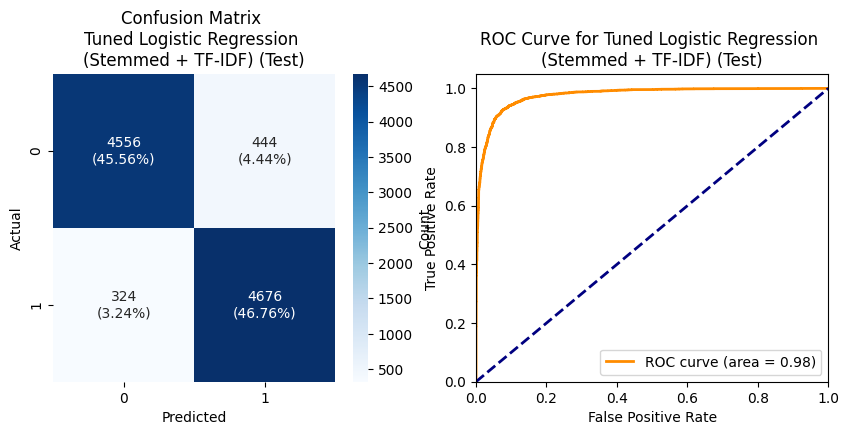


Tuned Logistic Regression 
(Stemmed + TF-IDF) (Test) Results:
Accuracy:  0.9232
Precision: 0.9133
Recall:    0.9352
F1-Score:  0.9241
ROC-AUC:   0.9762

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      5000
           1       0.91      0.94      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
config = best_models_combs['Logistic Regression']
tuned_lr_model = tuned_models['Logistic Regression']['model']
test_lr_metrics = evaluate_cls_model(tuned_lr_model, X_test_tfidf_stem, y_test, f"Tuned Logistic Regression \n({config}) (Test)", return_metrics = True)

Map: 100%|██████████| 10000/10000 [00:01<00:00, 7085.31 examples/s]


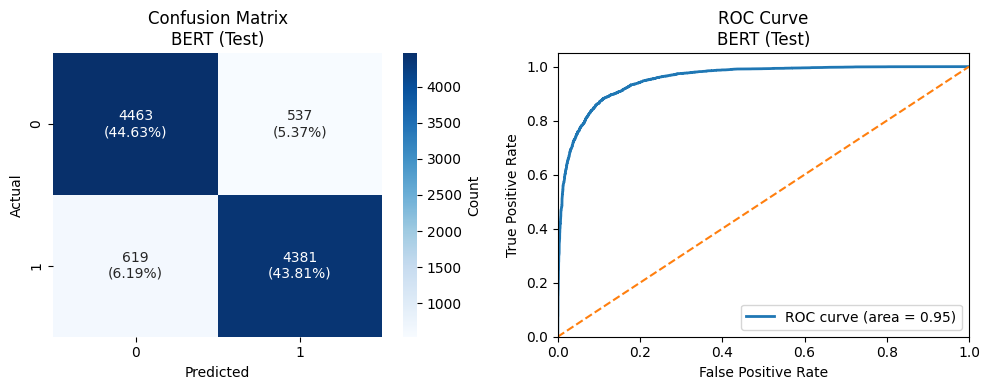


BERT (Test) Results:
Accuracy:  0.8844
Precision: 0.8908
Recall:    0.8762
F1-Score:  0.8834
ROC-AUC:   0.9544

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.89      0.89      5000
    positive       0.89      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
# Prepare test set for BERT testing
test_df = df_test.copy()
test_df["label"] = label_enc.transform(test_df["sentiment"])

# Convert to HuggingFace Dataset and tokenize
test_ds = Dataset.from_pandas(test_df[["review", "label"]].reset_index(drop=True))
test_ds = test_ds.map(tokenize_function, batched=True, remove_columns=["review"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Evaluate BERT on test set and plot graphs
bert_test_metrics = evaluate_bert(trainer, test_ds, label_enc, name="BERT (Test)")

- **F1-Score:** Logistic Regression (0.9241) edges out BERT (0.8834) by 4.07%, reflecting a better balance of precision and recall.
- **ROC-AUC:** Logistic Regression (0.9762) surpasses BERT (0.9544) by 0.0218, indicating superior ability to distinguish between classes.
- **Class Performance:** Logistic Regression shows higher recall (0.9352 vs. 0.8762), critical for minimizing false negatives, while BERT maintains slightly better precision consistency across classes.

------------------------------------------------------------------------------------------------------------------------------------------------
**Tuned Logistic Regression (Stemmed + TF-IDF)** emerges as the **top model**, excelling across all metrics on the test set. Its simplicity and effectiveness with TF-IDF features likely contribute to this edge over the more complex BERT model.

Despite its contextual strength, BERT underperformed, possibly due to early stopping at epoch 4 or suboptimal hyperparameter settings, which may not fully leverage its capacity on this dataset.